In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd

plt.style.use('/Users/mueller/Projects/GitRepos/ICARUSNoiseAnalysis/plot_style.mplstyle')
db_path = '/Users/mueller/Projects/channel_status/db/icarus_channels.db'

In [2]:
def map_channels(db_path, fragments):
    """
    Returns the permutation that orders the channels (as seen on an
    event display) for the given set of fragments.

    Parameters
    ----------
    db_path: str
        The full path of the SQLite file that contains the channel
        map.
    fragments: list[int] or list[str]
        The list of fragments to produce the permutation for.
        
    Returns
    -------
    permute: list[int]
        The indices that permute the combined waveforms of all channels
        in the fragment list into a properly ordered event display.
    """
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(f"SELECT channel_id,fragment_id,slot_id*64+local_id FROM channelinfo WHERE fragment_id IN ({','.join([str(f) for f in fragments])})", conn).to_numpy()
    conn.close()

    frag_local_to_channel = {(df[xi, 1], df[xi, 2]): df[xi, 0] for xi in range(df.shape[0])}
    u, c = np.unique(df[:,1], return_counts=True)
    frag_to_count = dict(zip(u, c))
    permute = np.argsort([frag_local_to_channel[(f, l)] for f in fragments for l in np.arange(frag_to_count[f], dtype='int')])
    return permute

def load_event(path, wtype=0, raw_only=False) -> np.array:
    """
    Loads the waveforms for a single component from the input file.

    Parameters
    ----------
    path: str
        The full path to the input file. ADC values are stored in a
        comma-separated format.
    wtype: int
        The type of waveform to load (0 = raw, 1 = intrinsic, 2 = coherent).
    raw_only: bool
        Boolean flag for switching between text file dumps which
        contain all components or just the raw waveforms.

    Returns
    -------
    waveforms: np.array
        The waveforms for the component with shape (576, 4096).
    """
    with open(path, 'r') as input_file:
        waveforms = np.array([x.split(',') for x in input_file.readlines()], dtype='float')
        if raw_only:
            return waveforms
        else:
            channels = int(waveforms.shape[0] / (3 if waveforms.shape[0] > 1088 else 1))
            return waveforms[wtype*channels:(wtype+1)*channels]
    
def plot_waveforms(paths, save_path=None, noise_filter=False, permute_channels=False, raw_dump=False) -> plt.figure:
    """
    Plots the waveforms for a single component from the input file.

    Parameters
    ----------
    paths: list[str]
        The full paths to the input files. ADC values are stored in a
        comma-separated format.
    save_path: str
        The full path specifying the location to save the plot.
    noise_filter: bool
        Boolean flag for switching on coherent noise filtering.
    permute_channels: bool
        Boolean flag for ordering the channels as they would appear
        on an event display instead of how they appear in the mini-
        crate.
    raw_dump: bool
        Boolean flag for switching between text file dumps which
        contain all components or just the raw waveforms.

    Returns
    -------
    figure: matplotlib.pyplot.figure
        The resulting figure with the waveforms.
    """
    figure = plt.figure(figsize=(16,4.75))
    ax = figure.add_subplot()
    waveforms = np.vstack([load_event(path, wtype=1 if noise_filter else 0) for path in paths])
    fragment_ids = [int(path.split('_')[-2][4:]) for path in paths]
    
    boards = int(waveforms.shape[0]/64)
    if noise_filter & raw_dump:
        signal_mask = np.abs(waveforms) < 10*np.sqrt(np.mean(np.square(waveforms), axis=1))[:, None]
        medians = list()
        for b in range(boards):
            board_mask = np.full(waveforms.shape, False)
            board_mask[b*64:(b+1)*64, :] = True
            medians.append(np.tile([np.median(waveforms[:, t][board_mask[:, t] & signal_mask[:, t]]) for t in range(waveforms.shape[1])], (64,1)))
        medians = np.vstack(medians)
        print(medians.shape)
        waveforms -= medians
    
    if permute_channels:
        permute = map_channels(db_path, fragment_ids)
        waveforms = waveforms[permute]
    ax.imshow(waveforms, cmap='binary', aspect=1.6, vmin=-20, vmax=20)
    ax.set_xticks([i*512 for i in range(9)])
    if boards < 10:
        ax.set_yticks([i*64 for i in range(10)])
    else:
        ax.set_yticks([i*256 for i in range(int(boards/4)+1)])
    ax.set_xlabel('Time [ticks]')
    ax.set_ylabel('Channel Number')
    if save_path is not None:
        figure.savefig(save_path)
    return figure

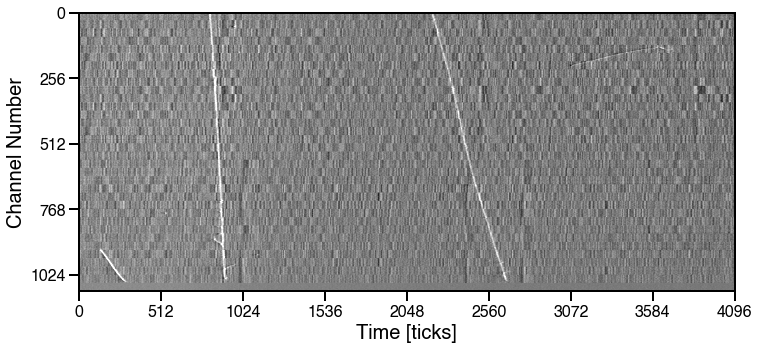

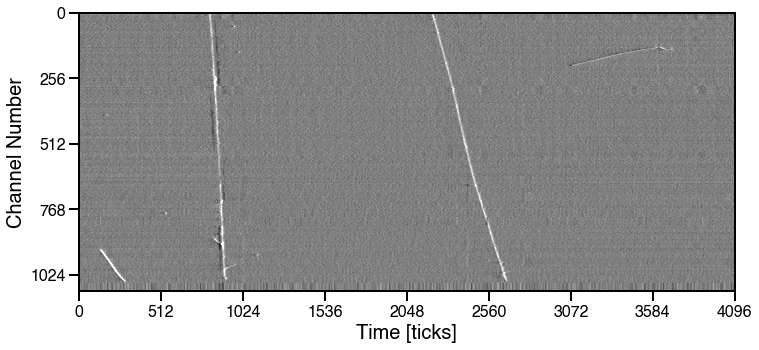

In [3]:
run = 10281
evt = 2 # 2#10
fragments = [5122,5120]
paths = [f'/Users/mueller/data/waveforms/all_components/run{run}_frag{f}_evt{evt}' for f in fragments]
paths_raw_only = [f'/Users/mueller/data/waveforms/all_components/run{run}_frag{f}_evt{evt}' for f in fragments]
_ = plot_waveforms(paths, save_path='/Users/mueller/data/signoise_plots/waveforms_ind1_signal_raw.pdf', noise_filter=False, permute_channels=True)
_ = plot_waveforms(paths, save_path='/Users/mueller/data/signoise_plots/waveforms_ind1_signal_filtered.pdf', noise_filter=True, permute_channels=True)

Assumptions:
1. Cross talk occurs between any pair of cables in close proximity.
2. There is a significant coherent noise source on the readout boards and common to all 64 channels of the board.

Conclusions:
1. Cable pairs connected to spatially adjacent wires have significant overlap (more cross talk). [Corners only]
2. 

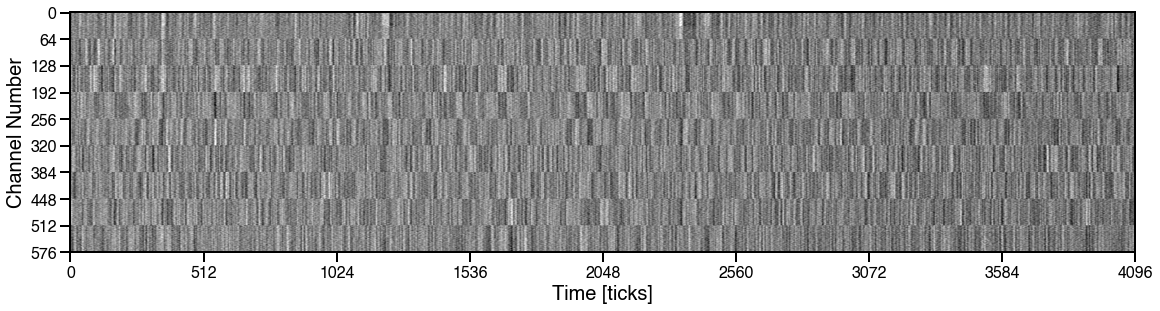

In [4]:
run = 10265
evt = 5
fragments = [5122]
paths = [f'/Users/mueller/data/waveforms/run{run}_frag{f}_evt{evt}' for f in fragments]
plot_waveforms(paths, save_path='/Users/mueller/data/signoise_plots/noise/waveforms_ind1_noise.pdf', noise_filter=False, permute_channels=False)

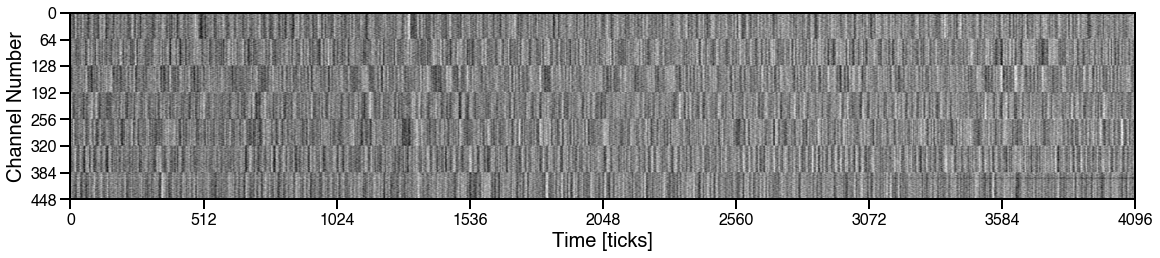

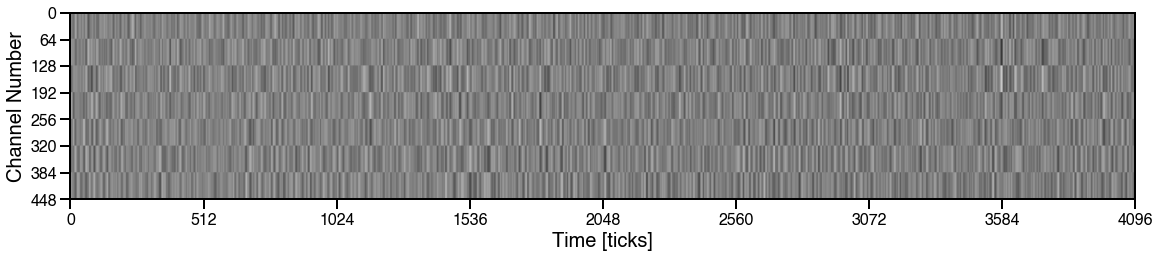

In [5]:
def board_segment(waveforms, b):
    segment = np.zeros((192, 4096))
    segment[:64, :] = -1*waveforms[(b-1)*64:(b+0)*64, :]
    segment[64:128, :] = waveforms[(b+0)*64:(b+1)*64, :]
    segment[128:, :] = -1*waveforms[(b+1)*64:(b+2)*64, :]
    anticoherent = np.tile(np.median(segment, axis=0), reps=[64,1])
    return anticoherent

def plot_waveforms_raw(waveforms):
    figure = plt.figure(figsize=(16,4.75))
    ax = figure.add_subplot()
    ax.imshow(waveforms, cmap='binary', aspect=1.6, vmin=-20, vmax=20)
    ax.set_xticks([i*512 for i in range(9)])
    ax.set_yticks([i*64 for i in range(8)])
    ax.set_xlabel('Time [ticks]')
    ax.set_ylabel('Channel Number')

waveforms = load_event('/Users/mueller/data/waveforms/run10265_frag5122_evt1')
plot_waveforms_raw(waveforms[64:512,:])

anticoherent = np.vstack([board_segment(waveforms, b) for b in range(1,8)])
plot_waveforms_raw(anticoherent)